## Name - Maitri Das
## Roll no. - 19HS20028

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'segmentation/'
FOLDERNAME = 'Segmentation'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Segmentation


## Import the libraries

In [ ]:
# standard libraries
import matplotlib
import numpy
import os
import sys
import glob
import pandas as pd
import random
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from sklearn.model_selection import train_test_split

# Pytorch Libraries
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensor
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchsummary import summary

## Load and Visualize data

Location of the dataset

In [ ]:
# If not preprocessed
dataset_path = "train_val"
img_path = dataset_path + "/images"
mask_path = dataset_path + "/masks"
print("Image path:", img_path)
print("Mask path:", mask_path)

Image path: train_val/images
Mask path: train_val/masks


List all images in the folder

In [ ]:
# Check images directory
image_list = [filename.split('/')[-1].split('\\')[-1].split('.')[0] for filename in glob.glob(img_path+"/*.jpg")]
image_ids = pd.DataFrame(image_list).rename(columns={0:"image_id"})
print(f"Number of images in the images directory: {len(image_ids)}")
image_ids.head()

Number of images in the images directory: 1525


,image_id
0,f_r_1947_
1,f_r_1219_
2,f_r_1956_
3,f_r_1365_
4,f_r_1501_


List all masks in the folder

In [ ]:
# check mask directories
mask_list = [filename.split('/')[-1].split('\\')[-1].split('.')[0] for filename in glob.glob(mask_path+"/*.bmp")]
mask_ids = pd.DataFrame(mask_list).rename(columns={0:"image_id"})
print(f"Number of images in masks directory: {len(mask_ids)}")
mask_ids.head()

Number of images in masks directory: 1525


,image_id
0,f_r_1538_
1,f_r_1766_
2,f_r_1750_
3,f_r_1464_
4,f_r_1866_


Check for invalid images or masks

In [ ]:
# checking whether all images has a mask
# assert len(image_ids)==len(mask_ids), "Some data mismatch is there"
found = False
# Delete images whose masks are not found
print("Deleted images")
for img in image_list:
    if img not in mask_list:
        found = True
        print(img, " No mask availaible")
        # os.remove(img_path+"/"+img+".jpg")
        image_ids.drop(image_ids.index[(image_ids.iloc[:, 0] == img)],axis=0,inplace=True)

# delete masks whose images not found
found = False
for mask in mask_list:
  if mask not in image_list:
    found = True
    print(mask, "Image not availaible")
        
if not found:
    print("All is good")

Deleted images
All is good


## Visualizing the images

In [ ]:
def display_img(img_id):
    """
    Function to return the image and its mask
    
    Parameters:
        img_id: Imgae id required 

    Returns:
      img: image 
      mask: mask of the image    
    """
    img = plt.imread(img_path+"/"+img_id+".jpg")
    mask = plt.imread(mask_path+"/"+img_id+".bmp")
    return img, mask

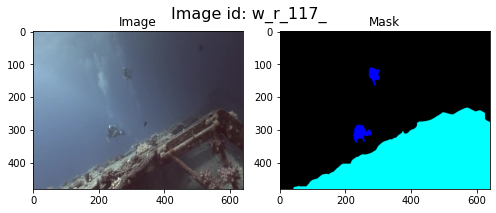

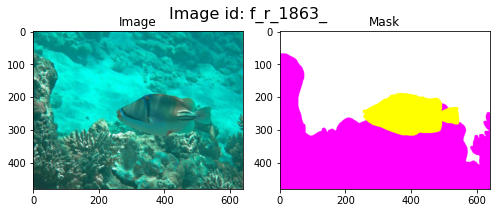

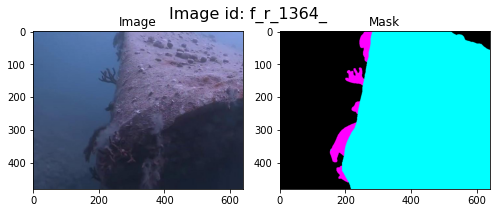

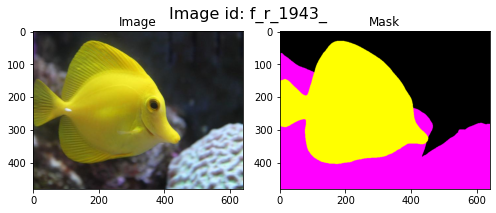

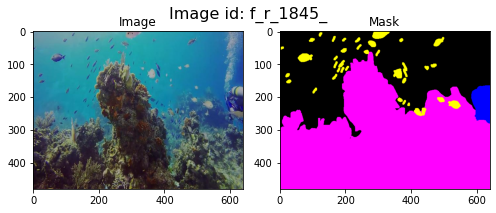

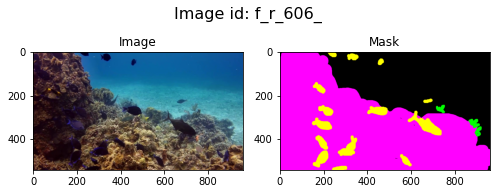

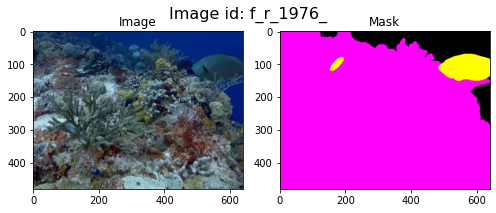

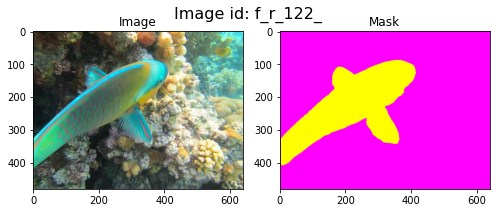

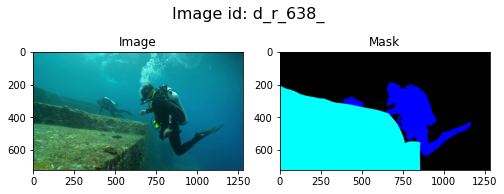

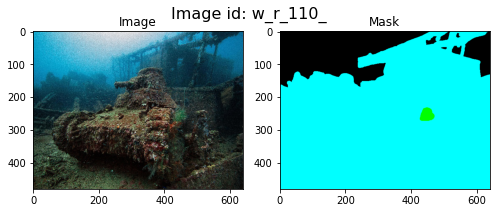

In [ ]:
img_ids = [image_ids.iloc[random.randint(0, len(image_ids)), 0] for i in range(10)]
for img_id in img_ids:    
    img, mask = display_img(img_id)

    NUM_ROWS = 1
    IMGs_IN_ROW = 2
    f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(7,3))

    ax[0].imshow(img)
    ax[1].imshow(mask)

    ax[0].set_title('Image')
    ax[1].set_title('Mask')

    title = 'Image id: ' + img_id
    f.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

## Data Preprocessing

Cropping and padding the images

In [ ]:
os.makedirs("preprocess/images", exist_ok=True)
os.makedirs("preprocess/masks", exist_ok=True)

In [ ]:
preprocess_dir = "preprocess"
image_dir = preprocess_dir+"/images"
mask_dir = preprocess_dir+"/masks"

In [ ]:
for i in range(len(image_ids)):
  img = PIL.Image.open(img_path+"/"+image_ids.iloc[i, 0]+".jpg")
  mask= PIL.Image.open(mask_path+"/"+image_ids.iloc[i, 0]+".bmp")
  if img.size[0]>=572 and img.size[1]>=572:
    transform = transforms.CenterCrop((572, 572))
    img = transform(img)
  else:
    pad = max(abs(img.size[0]-572), abs(img.size[1]-572))
    transform = transforms.Compose(
    [
     transforms.Pad(pad),
     transforms.CenterCrop((572, 572))
    ])
    img = transform(img)
  
  if mask.size[0]>=388 and mask.size[1]>=388:
    transform = transforms.CenterCrop((388, 388))
    mask = transform(mask)
  else:
    pad = max(abs(mask.size[0]-388), abs(mask.size[1]-388))
    transform = transforms.Compose(
    [
     transforms.Pad(pad),
     transforms.CenterCrop((388, 388))
    ])
    mask = transform(mask)

  img.save(image_dir+ "/" +image_ids.iloc[i, 0]+".jpg")
  mask.save(mask_dir+ "/" +image_ids.iloc[i, 0]+".bmp")
  if i%100==0: 
    print(f"{i+1} images done processing")

1 images done processing
101 images done processing
201 images done processing
301 images done processing
401 images done processing
501 images done processing
601 images done processing
701 images done processing
801 images done processing
901 images done processing
1001 images done processing
1101 images done processing
1201 images done processing
1301 images done processing
1401 images done processing
1501 images done processing


Splitting the rgb mask into 8 different masks

In [ ]:
# how many different colours are there that would be the number of classes
colours = set()
for i in range(len(mask_ids)):
  l = PIL.Image.open(mask_path+"/"+mask_ids.iloc[i, 0]+".bmp").getcolors()
  if l:
    for elem in l:
      colours.add(elem[1])
  if i%100==0:
    print(f"{i+1} masks are processed")
print(f"The colours are: {colours}")

1 masks are processed
101 masks are processed
201 masks are processed
301 masks are processed
401 masks are processed
501 masks are processed
601 masks are processed
701 masks are processed
801 masks are processed
901 masks are processed
1001 masks are processed
1101 masks are processed
1201 masks are processed
1301 masks are processed
1401 masks are processed
1501 masks are processed
The colours are: {(255, 255, 0), (0, 255, 255), (255, 255, 255), (0, 0, 255), (255, 0, 0), (255, 0, 255), (0, 0, 0), (0, 255, 0)}


In [ ]:
for k, col in enumerate(colours):
  print(k, col)

0 (255, 255, 0)
1 (0, 255, 255)
2 (255, 255, 255)
3 (0, 0, 255)
4 (255, 0, 0)
5 (255, 0, 255)
6 (0, 0, 0)
7 (0, 255, 0)


In [ ]:
def split(path, dir, img_id):
  """ 
    splitting the mask into masks of black and white colours

    Parameters:
      path: path of the mask
      dir: To save the seperated images
      img_id: image id of the array

    Returns:  
      None
  """
  mask = np.asarray(PIL.Image.open(path))
  # display(PIL.Image.open(path))
  images = np.zeros((8, mask.shape[0], mask.shape[1], 3))
  for k, colour in enumerate(colours):
    x = mask.copy()
    y = mask.copy()
    y[:,:,0] = np.where(((x[:,:,0]==colour[0]) & (x[:,:,1]==colour[1]) & (x[:,:, 2]==colour[2])), 255, 0)
    y[:,:,1] = np.where(((x[:,:,0]==colour[0]) & (x[:,:,1]==colour[1]) & (x[:,:, 2]==colour[2])), 255, 0)
    y[:,:,2] = np.where(((x[:,:,0]==colour[0]) & (x[:,:,1]==colour[1]) & (x[:,:, 2]==colour[2])), 255, 0)
    images[k, :, :, :]=y

  os.makedirs(dir+"/"+img_id, exist_ok=True)  
  # saving the images in grayscale
  for i in range(8):
    im = PIL.Image.fromarray(numpy.uint8(images[i, :, :, :]))
    im = im.convert('L')
    im.save(dir+"/"+img_id+"/"+img_id+str(i)+".bmp")

In [ ]:
split(path='preprocess/masks/'+"f_r_1822_"+".bmp", dir='test', img_id="f_r_1822_")

In [ ]:
# making a directory for the masks
os.makedirs('preprocess/mask_seperated', exist_ok=True)

# converting the masks for all masks
for i in range(len(image_ids)):
  path = 'preprocess/masks/'+image_ids.iloc[i, 0]+".bmp"
  split(path=path, dir='preprocess/mask_seperated', img_id=image_ids.iloc[i, 0])
  if i%100==0:
    print(f"{i+1} masks processed")

1 masks processed
101 masks processed
201 masks processed
301 masks processed
401 masks processed
501 masks processed
601 masks processed
701 masks processed
801 masks processed
901 masks processed
1001 masks processed
1101 masks processed
1201 masks processed
1301 masks processed
1401 masks processed
1501 masks processed


Visualize the seperated images

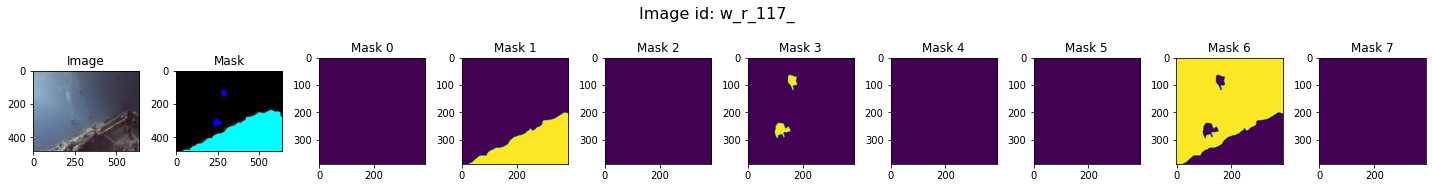

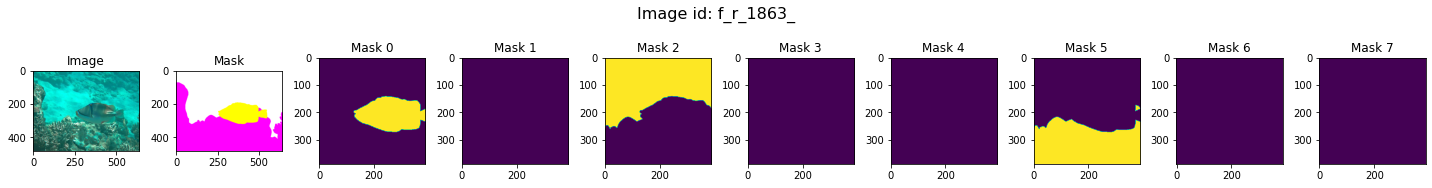

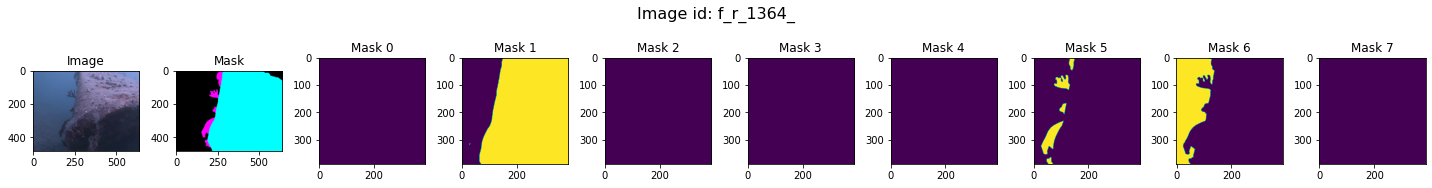

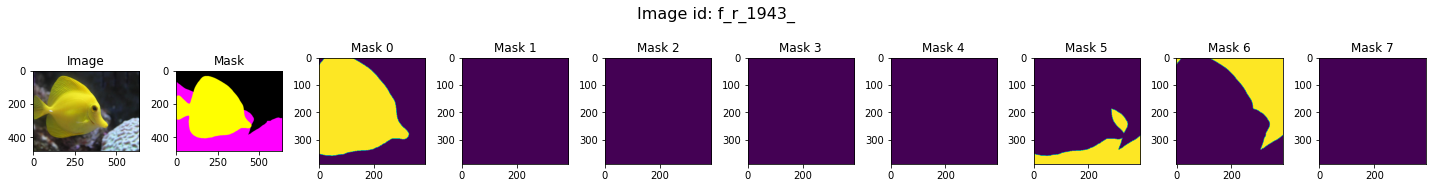

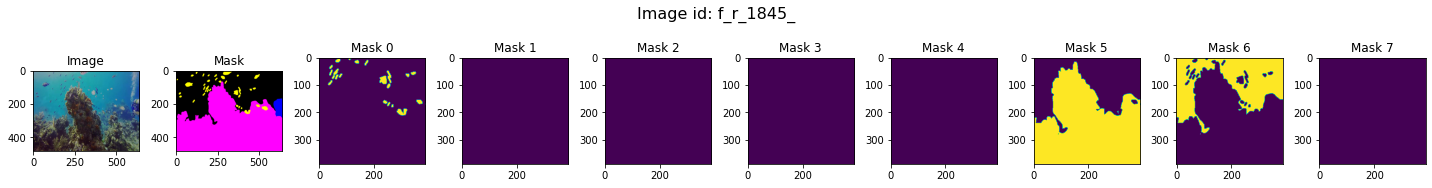

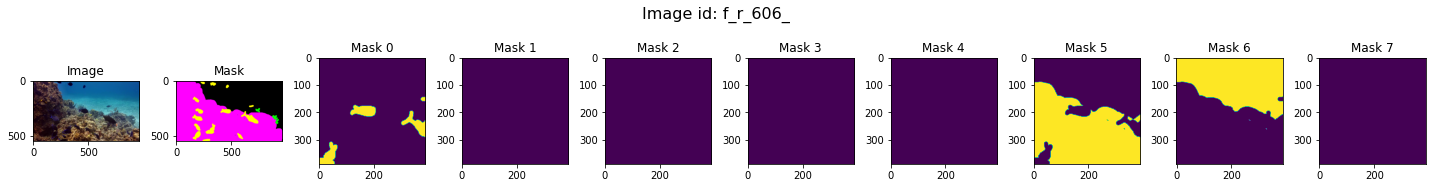

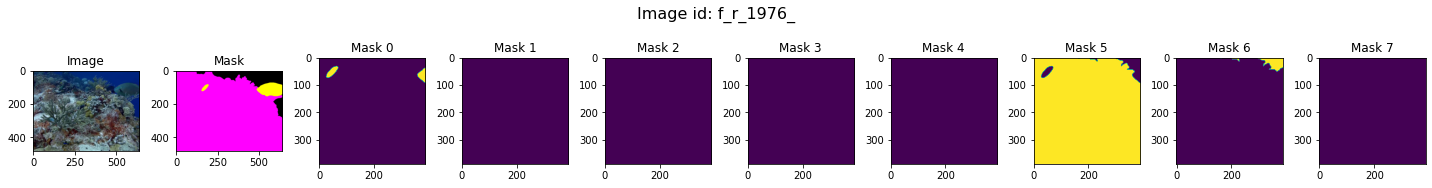

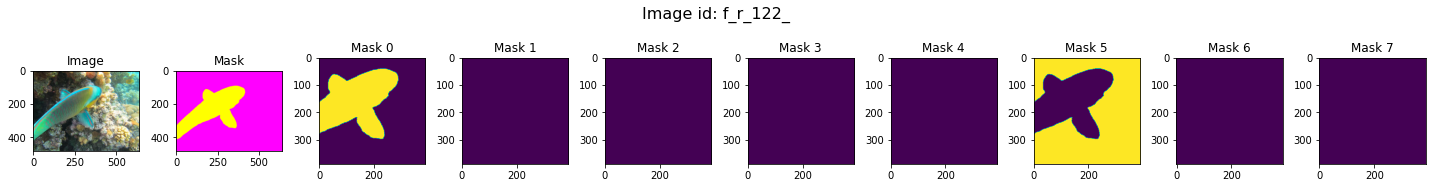

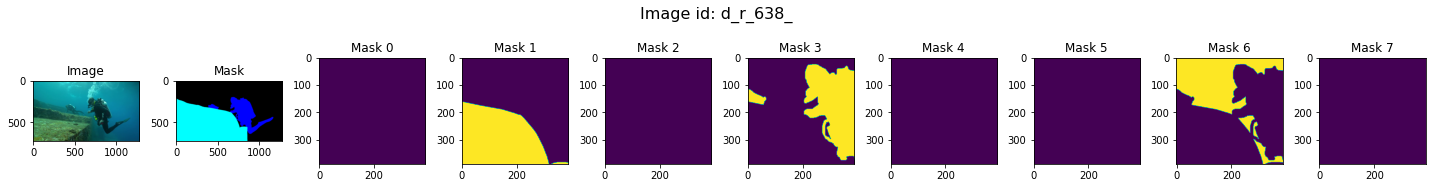

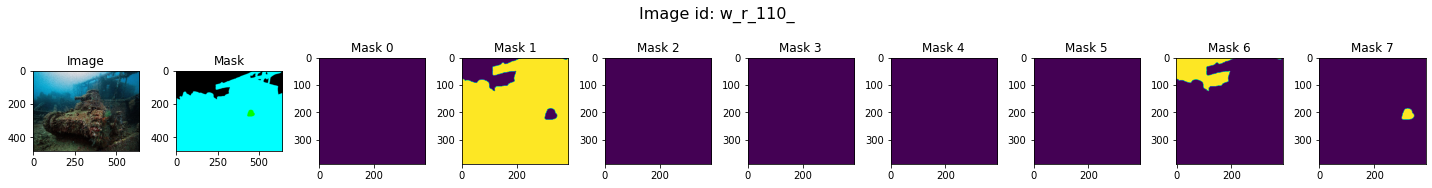

In [ ]:
for img_id in img_ids:    
    img, mask = display_img(img_id)

    NUM_ROWS = 1
    IMGs_IN_ROW = 10
    f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(20,3))

    ax[0].imshow(img)
    ax[1].imshow(mask)

    ax[0].set_title('Image')
    ax[1].set_title('Mask')

    for i in range(8):
      img = plt.imread('preprocess/mask_seperated/'+img_id+"/"+img_id+str(i)+".bmp")
      ax[i+2].imshow(img)
      ax[i+2].set_title('Mask '+str(i))

    title = 'Image id: ' + img_id
    f.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

## Seperate into Train and Validation set

Training on only 30 images to save training time

In [ ]:
train_set, val_set = train_test_split(image_ids[30:60], test_size=0.2, random_state=42)

In [ ]:
print("Length of the training set:", len(train_set))
print("Length of the validation set:", len(val_set))

Length of the training set: 24
Length of the validation set: 6


In [ ]:
train_set.head()

,image_id
58,f_r_1964_
54,f_r_1857_
42,f_r_1506_
30,f_r_1381_
34,f_r_1933_


In [ ]:
val_set.head()

,image_id
57,f_r_1626_
45,f_r_1451_
53,f_r_171_
47,f_r_1858_
38,f_r_1577_


In [ ]:
train_set = train_set['image_id'].tolist()
val_set = val_set['image_id'].tolist()

## Unet Model

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 0, bias=True),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        #print(x.shape)
        x = self.conv(x)
        #print(x.shape)
        return x
    
class UNET(nn.Module):
    def __init__(
        self, in_c=3, out_c=8, features = [64, 128, 256, 512] 
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        for feature in features:
            self.downs.append(DoubleConv(in_c, feature))
            in_c = feature
            
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
            
        self.bottom = DoubleConv(features[-1], features[-1]*2)
        self.finalconv = nn.Conv2d(features[0], out_c, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x=down(x)
            skip_connections.append(x)
            x = self.pool(x)
            
        x = self.bottom(x)
        skip_connections = skip_connections[::-1]
        
        skipidx = 0
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            #print(x.shape)
            skip_connection = skip_connections[skipidx]
            if x.shape != skip_connection.shape:
                #x = TF.resize(x, size=skip_connection.shape[2:])
                transform = transforms.CenterCrop((x.shape[2], x.shape[3]))
                skip_connection = transform(skip_connection)
                # skip_connection = TF.resize(skip_connection, size=x.shape[2:])
            #print(skip_connection.shape, skip_connection.shape[2:])
            skipidx +=1
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            
        return self.finalconv(x)

In [ ]:
def test():
    # batchsize, inputchannels, size, size
    x = torch.randn((3, 3, 572, 572))
    model = UNET(in_c=3, out_c=8)
    preds = model(x)
    print(preds.shape)
    print(x.shape)

In [ ]:
test()

torch.Size([3, 8, 388, 388])
torch.Size([3, 3, 572, 572])


In [ ]:
test_model = UNET()
summary(test_model, (3, 572, 572))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 570, 570]           1,792
              ReLU-2         [-1, 64, 570, 570]               0
            Conv2d-3         [-1, 64, 568, 568]          36,928
              ReLU-4         [-1, 64, 568, 568]               0
        DoubleConv-5         [-1, 64, 568, 568]               0
         MaxPool2d-6         [-1, 64, 284, 284]               0
            Conv2d-7        [-1, 128, 282, 282]          73,856
              ReLU-8        [-1, 128, 282, 282]               0
            Conv2d-9        [-1, 128, 280, 280]         147,584
             ReLU-10        [-1, 128, 280, 280]               0
       DoubleConv-11        [-1, 128, 280, 280]               0
        MaxPool2d-12        [-1, 128, 140, 140]               0
           Conv2d-13        [-1, 256, 138, 138]         295,168
             ReLU-14        [-1, 256, 1

## Set the data loader

In [ ]:
class segdataset(Dataset):
  def __init__(self, image_dir, mask_dir, image_set, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = image_set

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    # change these two lines later
    img_path = os.path.join(self.image_dir, f"{self.images[index]}.jpg")
    mask_path = os.path.join(self.mask_dir, self.images[index])
    image = np.array(PIL.Image.open(img_path).convert('RGB'))
    # print("image shape", image.shape)
    mask = np.zeros((8, 388, 388))
    for i in range(8):
      mask[i, :, :] = np.array(PIL.Image.open(mask_path+f"/{self.images[index]}{i}.bmp").convert('L'), dtype=np.float32)
    # print(np.unique(mask))
    mask[mask==255.0]=1.0 # because we using sigmoid in last layer indicating the probability

    if self.transform is not None:
      augmentation = self.transform(image=image, mask=mask)
      image = augmentation["image"]
      mask = augmentation["mask"]

    return image, mask

Utility Functions

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state, filename)

In [ ]:
def load_checkpoint(checkpoint, model):
  print("=> Loading Checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

In [ ]:
def get_loaders(
    train_dir,
    train_mask_dir,
    image_set,
    val_set,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True):
  train_ds = segdataset(
      image_dir = train_dir,
      mask_dir = train_mask_dir,
      transform = train_transform,
      image_set = image_set
  )

  train_loader = DataLoader(
      train_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = True
  )

  val_ds = segdataset(
      image_dir = val_dir,
      mask_dir = val_maskdir,
      image_set = val_set,
      transform = val_transform
  )

  val_loader = DataLoader(
      val_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = False
  )

  return train_loader, val_loader

In [ ]:
def check_accuracy(loader, model, device="cuda"):
  num_correct=0
  num_pixels=0
  model.eval()
  acc = 0
  steps = 0

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.squeeze(1).to(device)
      # print("x:", x.shape)
      # print("y:", y.shape)
      preds = torch.sigmoid(model(x))
      preds = (preds>0.5).float()
      # print("preds:", preds.shape)
      num_correct += (preds==y).sum()
      num_pixels += torch.numel(preds) 
      acc = num_correct/num_pixels
      step=steps+1
      num_correct=0
      num_pixels=0
  
  print(
      f"Got accuracy: {acc*100/step}"
  )
  model.train()
  return acc*100/step

In [ ]:
def check_loss(valloader, model, loss_fn, device="cuda"):
  loss =0
  running_loss = 0
  steps = 0
  model.eval()
  with torch.no_grad():
    for x, y in valloader:
      x = x.to(device)
      y = y.squeeze(1).to(device)
      preds = model(x)
      # print(y.shape, preds.shape)
      loss = loss_fn(preds, y)
      steps+=1
      running_loss += loss.item()

  model.train()
  print(
      f"Loss: {running_loss/steps}"
  )
  return running_loss/steps

Training the model

In [ ]:
# Hyperparameters

learning_rate = 1e-4
device = "cpu"
#"cuda" if torch.cuda.is_available() else "cpu"
batch_size = 8
num_epochs = 10
num_workers = 0
image_height = 572
image_width = 572
pin_memory = True
load_model = False
save_model = False
train_img_dir = "preprocess/images"
train_mask_dir = "preprocess/mask_seperated"
val_img_dir = train_img_dir
val_mask_dir = train_mask_dir
tot_train_size = len(train_set)

In [ ]:
def train_fn(loader, model, optimizer, loss_fn):
  loop = tqdm(loader)
  running_loss = 0
  accu = 0 
  steps = 0
  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=device)
    targets = targets.float().squeeze(1).to(device=device)
    # print(data.shape)
    # print(targets.shape)
    # break

    # forward
    #with torch.cuda.amp.autocast():
    predictions = model(data)
    loss = loss_fn(predictions, targets)

    # backward
    optimizer.zero_grad()
    loss.backward(loss)
    optimizer.step()

    # calculate loss and accuracy
    running_loss += loss.item()

    # update tqdm loop
    loop.set_postfix(loss=loss.item())
    steps += 1
  print("Training accuracy and loss:")
  accu = check_accuracy(loader, model, device)
  print("Loss: ", running_loss/steps)
  
  return running_loss/steps, accu

In [ ]:
# A.Normalize(
#          mean=[0.0,0.0,0.0],
#          std=[1.0,1.0,1.0],
#          max_pixel_value=255.0
#      ),
train_transform = A.Compose(
    [
     ToTensor()
    ]
)
val_transform = A.Compose(
    [
     ToTensor()
    ]
)

In [ ]:
model = UNET(in_c=3, out_c=8).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loss = {}
train_acc = {}
val_loss = {}
val_acc = {}

train_loader, val_loader = get_loaders(
    train_img_dir,
    train_mask_dir,
    train_set,
    val_set,
    val_img_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    num_workers,
    pin_memory
)

if load_model:
  load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

for epoch in range(1, num_epochs+1):
  print(f"Epoch {epoch}/{num_epochs}")
  trainloss, trainacc = train_fn(train_loader, model, optimizer, loss_fn)
  train_loss[epoch] = trainloss
  train_acc[epoch] = trainacc

  # save model
  checkpoint = {
      "state_dict": model.state_dict(),
      "optimizer": optimizer.state_dict()
  }
  if save_model:
    save_checkpoint(checkpoint)

  # check accuracy
  print("Validation Accuracy and Loss")
  valacc = check_accuracy(val_loader, model, device=device)
  valloss = check_loss(val_loader, model, loss_fn, device)

  val_loss[epoch] = valloss
  val_acc[epoch] = valacc
  
  # # print some examples to the folder
  # save_predictions_as_imgs(
  #     val_loader, model, folder="saved_images/", device=device
  # )

Epoch 1/10


100%|██████████| 3/3 [07:33<00:00, 151.16s/it, loss=2.03]


Training accuracy and loss:
Got accuracy: 49.447959899902344
Loss:  2.0325875282287598
Validation Accuracy and Loss
Got accuracy: 47.015907287597656
Loss: 1.9925814867019653
Epoch 2/10


100%|██████████| 3/3 [06:39<00:00, 133.09s/it, loss=2]


Training accuracy and loss:
Got accuracy: 49.673465728759766
Loss:  2.0238380829493203
Validation Accuracy and Loss
Got accuracy: 47.015907287597656
Loss: 1.9847321510314941
Epoch 3/10


100%|██████████| 3/3 [06:38<00:00, 132.99s/it, loss=2.02]


Training accuracy and loss:
Got accuracy: 46.92734909057617
Loss:  2.0158823331197104
Validation Accuracy and Loss
Got accuracy: 47.015907287597656
Loss: 1.9761016368865967
Epoch 4/10


100%|██████████| 3/3 [06:38<00:00, 132.84s/it, loss=2.01]


Training accuracy and loss:
Got accuracy: 47.55295944213867
Loss:  2.0051536560058594
Validation Accuracy and Loss
Got accuracy: 47.015907287597656
Loss: 1.9659279584884644
Epoch 5/10


100%|██████████| 3/3 [06:37<00:00, 132.37s/it, loss=1.97]


Training accuracy and loss:
Got accuracy: 50.37421417236328
Loss:  1.9923852284749348
Validation Accuracy and Loss
Got accuracy: 50.379539489746094
Loss: 1.951302409172058
Epoch 6/10


100%|██████████| 3/3 [06:37<00:00, 132.65s/it, loss=2.01]


Training accuracy and loss:
Got accuracy: 63.3593864440918
Loss:  1.9745345910390217
Validation Accuracy and Loss
Got accuracy: 62.46893310546875
Loss: 1.9252821207046509
Epoch 7/10


100%|██████████| 3/3 [06:36<00:00, 132.30s/it, loss=1.87]


Training accuracy and loss:
Got accuracy: 71.94703674316406
Loss:  1.929288427035014
Validation Accuracy and Loss
Got accuracy: 71.29971313476562
Loss: 1.8348190784454346
Epoch 8/10


100%|██████████| 3/3 [06:33<00:00, 131.13s/it, loss=1.51]


Training accuracy and loss:
Got accuracy: 71.78569030761719
Loss:  1.7266595363616943
Validation Accuracy and Loss
Got accuracy: 77.5710678100586
Loss: 2.2736470699310303
Epoch 9/10


100%|██████████| 3/3 [06:40<00:00, 133.49s/it, loss=1.52]


Training accuracy and loss:
Got accuracy: 80.48033142089844
Loss:  1.878530740737915
Validation Accuracy and Loss
Got accuracy: 76.40597534179688
Loss: 1.651361346244812
Epoch 10/10


100%|██████████| 3/3 [06:39<00:00, 133.12s/it, loss=1.77]


Training accuracy and loss:
Got accuracy: 72.95304870605469
Loss:  1.699858029683431
Validation Accuracy and Loss
Got accuracy: 72.45201873779297
Loss: 1.7734301090240479


## Plot Loss

Next to do
- plot training loss and validation loss
- plot training accuracy and validation accuracy
- visualize predictions

In [ ]:
train_acc

{1: tensor(49.4480),
 2: tensor(49.6735),
 3: tensor(46.9273),
 4: tensor(47.5530),
 5: tensor(50.3742),
 6: tensor(63.3594),
 7: tensor(71.9470),
 8: tensor(71.7857),
 9: tensor(80.4803),
 10: tensor(72.9530)}

In [ ]:
train_loss

{1: 2.0325875282287598,
 2: 2.0238380829493203,
 3: 2.0158823331197104,
 4: 2.0051536560058594,
 5: 1.9923852284749348,
 6: 1.9745345910390217,
 7: 1.929288427035014,
 8: 1.7266595363616943,
 9: 1.878530740737915,
 10: 1.699858029683431}

In [ ]:
val_acc

{1: tensor(47.0159),
 2: tensor(47.0159),
 3: tensor(47.0159),
 4: tensor(47.0159),
 5: tensor(50.3795),
 6: tensor(62.4689),
 7: tensor(71.2997),
 8: tensor(77.5711),
 9: tensor(76.4060),
 10: tensor(72.4520)}

In [ ]:
val_loss

{1: 1.9925814867019653,
 2: 1.9847321510314941,
 3: 1.9761016368865967,
 4: 1.9659279584884644,
 5: 1.951302409172058,
 6: 1.9252821207046509,
 7: 1.8348190784454346,
 8: 2.2736470699310303,
 9: 1.651361346244812,
 10: 1.7734301090240479}

## Plotting training and validation loss with respect to epoch

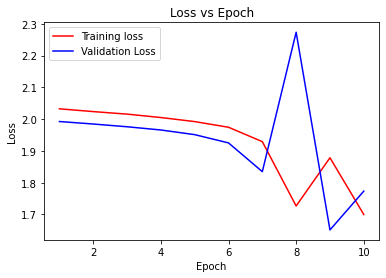

In [ ]:
fig,ax = plt.subplots()
ax.plot(list(train_loss.keys()),list(train_loss.values()),c='r',label='Training loss')
ax.plot(list(val_loss.keys()),list(val_loss.values()),c='b',label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Loss vs Epoch')
plt.show()

## Plotting the Training and validation accuracy

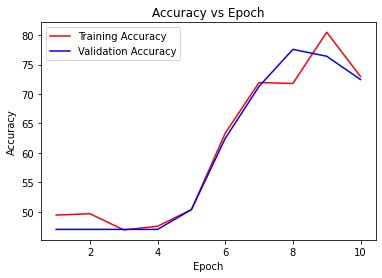

In [ ]:
fig,ax = plt.subplots()
ax.plot(list(train_acc.keys()),list(train_acc.values()),c='r',label='Training Accuracy')
ax.plot(list(val_acc.keys()),list(val_acc.values()),c='b',label='Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_title('Accuracy vs Epoch')
plt.show()

## Interesting points

- In the local machine even with 8 gb ram the highest batch size we can take is 8
- It takes too much time to train on the whole dataset, so to reduce the training time, I reduced the no. of epochs and the size of the data set for example here we are only training on 30 images for 10 epochs, It took nearly 60 minutes to train
- But because of this problems that we might face is that not all classes are trained as a result so we will get biased results